<div class="alert alert-block alert-info">
<h1> Titanic: Machine Learning from Disaster </h1> </div>

### Defining the problem statement
Complete the analysis of what sorts of people were likely to survive.  
In particular, we ask you to apply the tools of machine learning to predict which passengers survived the Titanic tragedy.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir("E:\Kaggle\Titanic ML")

### Collecting the data

Training data set and testing data set are given by Kaggle

In [3]:
train = pd.read_csv("train.csv")

In [4]:
test = pd.read_csv("test.csv")

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary
- Survived: 	0 = No, 1 = Yes  
- pclass: 	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  	
- sibsp:	# of siblings / spouses aboard the Titanic  	
- parch:	# of parents / children aboard the Titanic  	
- ticket:	Ticket number	
- cabin:	Cabin number	
- embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

<div class="alert alert-block alert-info">
<h1> For serious exploratory data analysis.</h1>
<h3> We could use pandas profiling. </h3>
<h3> import pandas_profiling </h3>
<h3> train.profile_report() </h3> </div>

In [6]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


#### Which Features are Categorical??
###### Survived, Sex, and Embarked. 
###### Ordinal: Pclass

#### Which features are numerical?
##### Age, Fare. Discrete: SibSp, Parch.

In [7]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

##### Based on Survived and Not Survived, we trying to see the count of how many of males and females Survived

<AxesSubplot:xlabel='Survived', ylabel='count'>

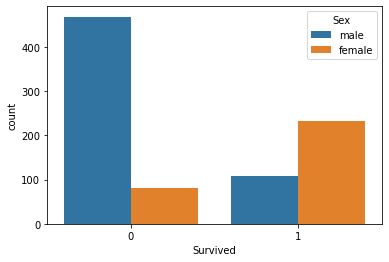

In [10]:
sns.countplot(x = "Survived",hue = "Sex" , data = train)

#### No matter how we disect the dataset, we find a similar pattern of womens from first class surviving, and in general Females surviving.

### Feature Engineering

#### Feature 1: Pclass

In [11]:
train.pivot_table("Survived",["Sex", "Age"], "Pclass")

Pclass          1    2     3
Sex    Age                  
female 0.75   NaN  NaN  1.00
       1.00   NaN  NaN  1.00
       2.00   0.0  1.0  0.25
       3.00   NaN  1.0  0.00
       4.00   NaN  1.0  1.00
...           ...  ...   ...
male   70.00  0.0  0.0   NaN
       70.50  NaN  NaN  0.00
       71.00  0.0  NaN   NaN
       74.00  NaN  NaN  0.00
       80.00  1.0  NaN   NaN

[145 rows x 3 columns]

In [12]:
print( train[["Pclass","Survived"]].groupby(["Pclass"], as_index = False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


It is obvious that the class of passenger is directly proportional to survival rate. If the importance of a person is more than others, they’ll get out of the disaster first. And our data tells the same story. 63% of people survived from Class 1. Therefore, this feature is definitely impactful.

#### Feature 2: Sex

In [13]:
train.groupby("Sex")[["Survived"]].mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [14]:
print( train[["Sex","Survived"]].groupby(["Sex"], as_index = False).mean() )

      Sex  Survived
0  female  0.742038
1    male  0.188908


Female and children were saved first during this tragedy. We can see that 74% of all females were saved and only 18% of all males were saved. Again, this will impact our outcome.

#### Feature 3: Family/Alone Feature

In [15]:
data = [train, test]
for dataset in data:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['Relatives'] > 0, 'TravelledAlone'] = 'No'
    dataset.loc[dataset['Relatives'] == 0, 'TravelledAlone'] = 'Yes'
    #dataset['travelled_alone'] = dataset['travelled_alone'].astype(int)
train['TravelledAlone'].value_counts()

Yes    537
No     354
Name: TravelledAlone, dtype: int64

In [16]:
test['TravelledAlone'].value_counts()

Yes    253
No     165
Name: TravelledAlone, dtype: int64

In [17]:
print (train[['TravelledAlone', 'Survived']].groupby(['TravelledAlone'], as_index=False).mean())

  TravelledAlone  Survived
0             No  0.505650
1            Yes  0.303538


Categorizing people to check whether they are alone in this ship or not. And after looking through it too, it seems to have a considerable impact on our output.

#### Feature 4: Embarked

This column has plenty of Missing Values. To deal with it, replacing the null with "S" because it is the most occurred value.

In [18]:
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [19]:
print( train[["Embarked","Survived"]].groupby(["Embarked"], as_index = False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


#### Feature 5: Fare

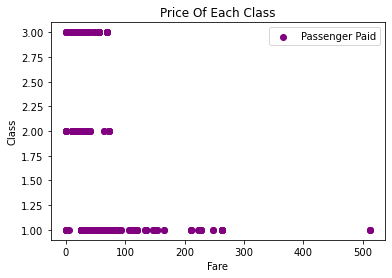

In [20]:
plt.scatter(train["Fare"], train["Pclass"], color = "purple", label = "Passenger Paid")
plt.xlabel("Fare")
plt.ylabel("Class")
plt.title("Price Of Each Class")
plt.legend()
plt.show()

There are missing data in this column as well. To fix the issue here, we are going to take the median value of the entire column.

In [21]:
data = [train, test]
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

In [22]:
data = [train, test]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [23]:
print( train[["Fare","Survived"]].groupby(["Fare"], as_index = False).mean())

   Fare  Survived
0     0  0.197309
1     1  0.308756
2     2  0.445415
3     3  0.532544
4     4  0.727273
5     5  0.777778


#### Feature 6: Age

Age has some missing values. So we impute the values with average age of the people in each class. 

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

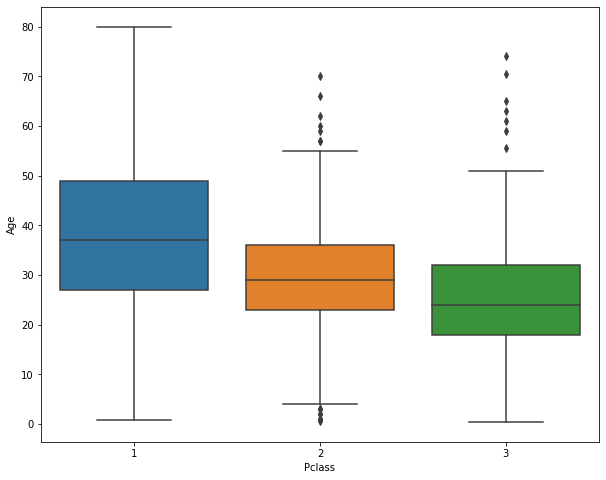

In [24]:
plt.figure(figsize= (10,8))
sns.boxplot(x = "Pclass", y = "Age", data = train)

In [25]:
def impute_age(col):
    Age = col[0]
    Pclass = col[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 23
    else:
        return Age

In [26]:
train["Age"] = train[["Age", "Pclass"]].apply(impute_age, axis=1)

In [27]:
test["Age"] = test[["Age", "Pclass"]].apply(impute_age, axis=1)

In [28]:
print( train[["Age","Survived"]].groupby(["Age"], as_index = False).mean())

      Age  Survived
0    0.42       1.0
1    0.67       1.0
2    0.75       1.0
3    0.83       1.0
4    0.92       1.0
..    ...       ...
83  70.00       0.0
84  70.50       0.0
85  71.00       0.0
86  74.00       0.0
87  80.00       1.0

[88 rows x 2 columns]


#### Feature 7: Name

Getting the title from the name and storing them in a new list called title. Replacing titles with a more common title or as Rare. And so that we dont have a null value, filling NaN with 0.

In [29]:
data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].fillna("NA")
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [30]:
print(train[['Title','Survived']].groupby(['Title'], as_index = False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [31]:
print(pd.crosstab(train['Title'], train['Sex']))

Sex     female  male
Title               
Master       0    40
Miss       185     0
Mr           0   517
Mrs        126     0
Rare         3    20


In [32]:
train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,TravelledAlone,Title
0,1,0,3,male,22.0,1,0,A/5 21171,0,NaN,S,1,No,Mr
1,2,1,1,female,38.0,1,0,PC 17599,3,C85,C,1,No,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,1,NaN,S,0,Yes,Miss
3,4,1,1,female,35.0,1,0,113803,3,C123,S,1,No,Mrs
4,5,0,3,male,35.0,0,0,373450,1,NaN,S,0,Yes,Mr
5,6,0,3,male,23.0,0,0,330877,1,NaN,Q,0,Yes,Mr
6,7,0,1,male,54.0,0,0,17463,3,E46,S,0,Yes,Mr
7,8,0,3,male,2.0,3,1,349909,2,NaN,S,4,No,Master
8,9,1,3,female,27.0,0,2,347742,1,NaN,S,2,No,Mrs
9,10,1,2,female,14.0,1,0,237736,2,NaN,C,1,No,Mrs


In [33]:
test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,TravelledAlone,Title
0,892,3,male,34.5,0,0,330911,0,NaN,Q,0,Yes,Mr
1,893,3,female,47.0,1,0,363272,0,NaN,S,1,No,Mrs
2,894,2,male,62.0,0,0,240276,1,NaN,Q,0,Yes,Mr
3,895,3,male,27.0,0,0,315154,1,NaN,S,0,Yes,Mr
4,896,3,female,22.0,1,1,3101298,1,NaN,S,2,No,Mrs
5,897,3,male,14.0,0,0,7538,1,NaN,S,0,Yes,Mr
6,898,3,female,30.0,0,0,330972,0,NaN,Q,0,Yes,Miss
7,899,2,male,26.0,1,1,248738,2,NaN,S,2,No,Mr
8,900,3,female,18.0,0,0,2657,0,NaN,C,0,Yes,Mrs
9,901,3,male,21.0,2,0,A/4 48871,2,NaN,S,2,No,Mr


### Mapping Data

We have to map our data to numerical values and convert the columns to the integer data type. ML algorithms only take numerical values and not strings.

In [34]:
#Mapping Sex
data = [train, test]
for dataset in data:
    sex_map = { 'female':0 , 'male':1 }
    dataset['Sex'] = dataset['Sex'].map(sex_map).astype(int)

In [35]:
 #Mapping Title
data = [train, test]
for dataset in data:
    title_map = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
    dataset['Title'] = dataset['Title'].map(title_map)
    dataset['Title'] = dataset['Title'].fillna(0)

In [36]:
#Mapping Embarked
data = [train, test]
for dataset in data:
    embark_map = {'S':0, 'C':1, 'Q':2}
    dataset['Embarked'] = dataset['Embarked'].map(embark_map).astype(int)

In [37]:
 #Mapping Age
data = [train, test]
for dataset in data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] 

In [38]:
#Mapping ravelledAlone
data = [train, test]
for dataset in data:
    sex_map = { 'No':0 , 'Yes':1 }
    dataset['TravelledAlone'] = dataset['TravelledAlone'].map(sex_map).astype(int)

In [39]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,TravelledAlone,Title
0,1,0,3,1,1.0,1,0,A/5 21171,0,NaN,0,1,0,1
1,2,1,1,0,2.0,1,0,PC 17599,3,C85,1,1,0,3
2,3,1,3,0,1.0,0,0,STON/O2. 3101282,1,NaN,0,0,1,2
3,4,1,1,0,2.0,1,0,113803,3,C123,0,1,0,3
4,5,0,3,1,2.0,0,0,373450,1,NaN,0,0,1,1


In [40]:
train.drop(["PassengerId","Ticket", "Cabin", "SibSp", "Parch","Relatives"], axis = 1, inplace=True)

In [41]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,TravelledAlone,Title
0,0,3,1,1.0,0,0,0,1
1,1,1,0,2.0,3,1,0,3
2,1,3,0,1.0,1,0,1,2
3,1,1,0,2.0,3,0,0,3
4,0,3,1,2.0,1,0,1,1


In [42]:
test.drop(["Ticket", "Cabin", "SibSp", "Parch","Relatives"], axis = 1, inplace=True)

In [43]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,TravelledAlone,Title
0,892,3,1,2.0,0,2,1,1
1,893,3,0,2.0,0,0,0,3
2,894,2,1,3.0,1,2,1,1
3,895,3,1,1.0,1,0,1,1
4,896,3,0,1.0,1,0,0,3


### Prediction

X_train : Contains all the features <br>
Y_train : Contains the actual output, in our case, Survived

In [44]:
#Train and Test Data
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()

In [45]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,TravelledAlone,Title
0,3,1,1.0,0,0,0,1
1,1,0,2.0,3,1,0,3
2,3,0,1.0,1,0,1,2
3,1,0,2.0,3,0,0,3
4,3,1,2.0,1,0,1,1


In [46]:
Y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [47]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked,TravelledAlone,Title
0,3,1,2.0,0,2,1,1
1,3,0,2.0,0,0,0,3
2,2,1,3.0,1,2,1,1
3,3,1,1.0,1,0,1,1
4,3,0,1.0,1,0,0,3


In [48]:
#Running our classifier
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
accuracy = round(decision_tree.score(X_train, Y_train) * 100, 2)
print("Model Accuracy: ",accuracy)

Model Accuracy:  87.32


In [49]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

result_train = logreg.score(X_train, Y_train)
result_val = cross_val_score(logreg,X_train, Y_train, cv=5).mean()
print('Score = %s , while validation score = %s' %(result_train , result_val))

Score = 0.7811447811447811 , while validation score = 0.7822861088443915


In [50]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

seed= 42
random_forest =RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=5, min_samples_split=2,
                           min_samples_leaf=1, max_features='auto',    bootstrap=False, oob_score=False, 
                           n_jobs=1, random_state=seed,verbose=0)

random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

result_train = random_forest.score(X_train, Y_train)
result_val = cross_val_score(random_forest,X_train, Y_train, cv=5).mean()

print('taring score = %s , while validation score = %s' %(result_train , result_val))

taring score = 0.835016835016835 , while validation score = 0.821542903772519


In [51]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived": Y_pred})
submission.to_csv('titanicsub.csv', index=False)
print('Exported')

Exported
